# Support Vector Machines

## Imports

In [15]:
import pandas as pd
import numpy as np
import cleaner
import re
import torch
import nltk
import contractions
import seaborn as sns

from tqdm.notebook import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_en = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

bert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
bert_model = AutoModel.from_pretrained("microsoft/codebert-base")

import spacy

nlp = spacy.load('en_core_web_lg')

tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In [8]:
TARGET = [
    'C', 'C#', 'C++', 'Dart', 'Elixir', 'Go', 'JSON', 'Java', 
    'Javascript', 'Julia', 'Kotlin', 'Markdown', 'Ruby', 'Rust', 'Python'
]

In [2]:
def clean_comments(contents, language) -> str:
    delimiters = cleaner.lang(language)

    if delimiters is not None:
        contents = cleaner.string(contents, *delimiters)

    return contents


def clean_extras(contents) -> str:
    contents = re.sub(r"[\r]", "", contents)
    contents = re.sub(r"\w{15,}", "", contents)
    contents = re.sub("[\n]{2,}", "\n", contents)
    contents = re.sub("[\t]{2,}", "\t", contents)
    contents = re.sub(r"[ ]+", " ", contents)

    contents = "\n".join(
        [line for line in contents.splitlines() if len(line.strip()) != 0]
    )

    return contents


def tokenize_bert(source: str):
    tokens = bert_tokenizer.tokenize(
        source, return_tensors="pt", truncation=True, max_length=512
    )
    lemmas = [
        lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en
    ]
    return bert_tokenizer.convert_tokens_to_ids(lemmas)


def vectorize_bert(tokens) -> np.ndarray:
    with torch.no_grad():
        outputs = bert_model(torch.tensor(tokens)[None, :])

    # We use the [CLS] token's embedding as the representation of the entire code snippet
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    return cls_embedding

def vectorize_spacy(texto: str) -> np.ndarray:
    texto = texto.lower()
    texto = contractions.fix(texto)
    texto = re.sub(r'[^A-Za-z\s]', '', texto)
    tokens = word_tokenize(texto)
    
    # Porque queremos encontrar las palabras en el diccionario no usamos stemming
    lemmas = (lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en)
    
    resultado = " ".join(lemmas)
    vector = nlp(resultado[:1000000]).vector
    
    return vector

def predict_bert(source, verbose = False, multi = [], single = []):
    # cleaned = clean(ccleaner.clean_string(source, multi, single), "")
    vec = vectorize_bert(tokenize_bert(clean_extras(source))).reshape(1,-1)
    resultado = model.predict(vec)


    return TARGET[resultado[0]]

## CodeBERT Embeddings

In [4]:
df = pd.concat([
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_0'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_1'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_2'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_3'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_4'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_5'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_6'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_7'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_8'),
	pd.read_pickle('../scripts/fbert_clean_3000x512_aprox_9'),
])

In [5]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 768)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [8]:
model = SVC(C=12)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
print(classification_report(y_test, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.84      0.82      0.83      2653
          C#       0.98      0.98      0.98      2700
         C++       0.81      0.85      0.83      2700
        Dart       0.94      0.92      0.93      2700
      Elixir       0.97      0.97      0.97      2700
          Go       0.99      1.00      0.99      2700
        JSON       0.98      1.00      0.99      2700
        Java       0.96      0.97      0.96      2700
  Javascript       0.94      0.95      0.95      2700
       Julia       0.97      0.96      0.96      2700
      Kotlin       0.99      0.99      0.99      2700
    Markdown       0.96      0.97      0.96      2700
        Ruby       0.98      0.98      0.98      2700
        Rust       0.97      0.96      0.97      2700
      Python       1.00      0.84      0.91       497

    accuracy                           0.95     38250
   macro avg       0.95      0.94      0.95     38250
weighted avg       0.95   

<Axes: >

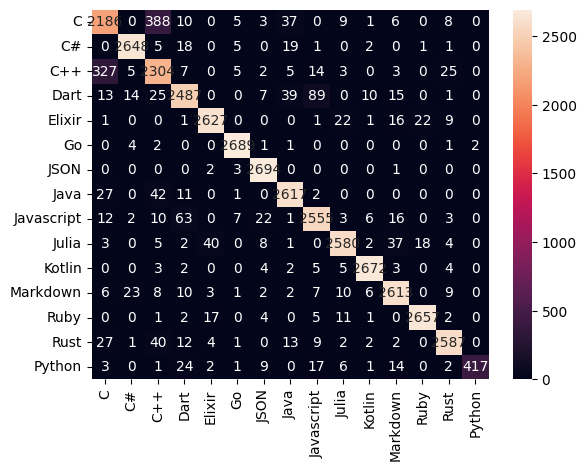

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

## TF-IDF Embeddings

### Comments Cleaned

In [12]:
df = pd.read_pickle('../scripts/clean_chunks')

In [13]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

In [14]:
from sklearn.model_selection import train_test_split

X = df['source']
y = df['lang']

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [16]:
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

In [17]:
model = SVC(C=12)

model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

In [18]:
print(classification_report(y_test, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.87      0.91      0.89      2653
          C#       0.97      0.98      0.97      2700
         C++       0.81      0.91      0.86      2700
        Dart       0.96      0.94      0.95      2700
      Elixir       0.99      0.97      0.98      2700
          Go       0.98      0.97      0.98      2700
        JSON       1.00      0.97      0.99      2700
        Java       1.00      0.95      0.97      2700
  Javascript       0.95      0.96      0.96      2700
       Julia       0.97      0.95      0.96      2700
      Kotlin       0.99      0.99      0.99      2700
    Markdown       0.93      0.96      0.94      2700
        Ruby       1.00      0.99      0.99      2700
        Rust       0.99      0.98      0.99      2700
      Python       1.00      0.64      0.78       497

    accuracy                           0.96     38250
   macro avg       0.96      0.94      0.95     38250
weighted avg       0.96   

<Axes: >

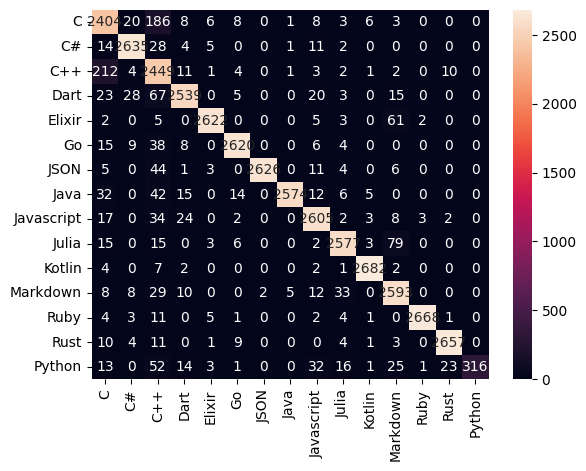

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

### Comments left

In [2]:
df = pd.read_pickle('../scripts/dirty_chunks')

In [3]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

NameError: name 'TARGET' is not defined

In [22]:
from sklearn.model_selection import train_test_split

X = df['source']
y = df['lang']

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [24]:
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

In [25]:
model = SVC(C=12)

model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

In [26]:
print(classification_report(y_test, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.81      0.87      0.84      2700
          C#       1.00      0.97      0.99      2700
         C++       0.88      0.91      0.89      2700
        Dart       0.96      0.92      0.94      2700
      Elixir       0.99      0.97      0.98      2700
          Go       0.99      0.92      0.96      2700
        JSON       1.00      0.95      0.98      2700
        Java       0.98      0.95      0.96      2700
  Javascript       0.92      0.96      0.94      2700
       Julia       0.97      0.97      0.97      2700
      Kotlin       0.99      0.97      0.98      2700
    Markdown       0.78      0.97      0.87      2700
        Ruby       1.00      0.98      0.99      2700
        Rust       0.99      0.96      0.97      2700
      Python       1.00      0.61      0.76       578

    accuracy                           0.94     38378
   macro avg       0.95      0.93      0.93     38378
weighted avg       0.95   

<Axes: >

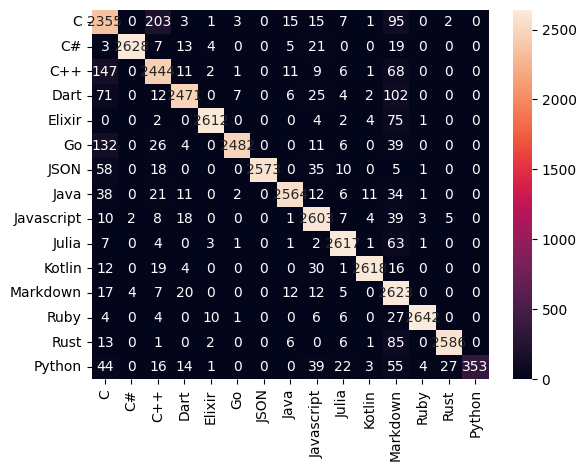

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

## spaCy

### Cleaned comments

In [9]:
df = pd.read_pickle('../scripts/clean_chunks')

In [11]:
df['vector'] = df['source'].progress_apply(vectorize_spacy)

  0%|          | 0/42501 [00:00<?, ?it/s]

In [12]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 300)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [16]:
model = SVC(C=12)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.74      0.75      0.74      2653
          C#       0.98      0.97      0.97      2700
         C++       0.67      0.76      0.71      2700
        Dart       0.91      0.88      0.89      2700
      Elixir       0.88      0.89      0.89      2700
          Go       0.79      0.94      0.86      2700
        JSON       0.98      0.98      0.98      2700
        Java       0.96      0.92      0.94      2700
  Javascript       0.89      0.83      0.86      2700
       Julia       0.88      0.85      0.87      2700
      Kotlin       0.98      0.93      0.95      2700
    Markdown       0.90      0.89      0.90      2700
        Ruby       0.95      0.91      0.93      2700
        Rust       0.96      0.93      0.95      2700
      Python       0.86      0.64      0.74       497

    accuracy                           0.89     38250
   macro avg       0.89      0.87      0.88     38250
weighted avg       0.89   

<Axes: >

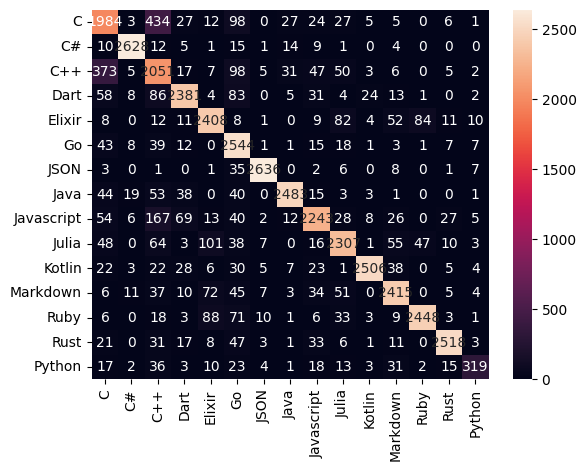

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)

### Left comments

In [23]:
df = pd.read_pickle('../scripts/dirty_chunks')

In [27]:
df['vector'] = df['source'].progress_apply(vectorize_spacy)

  0%|          | 0/42643 [00:00<?, ?it/s]

In [28]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df['lang'] = df['language'].map(mapper)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X = df['vector']
# X = np.concatenate(X, axis=0).reshape(-1, 300)
X = np.vstack(X).reshape(-1, 300)
y = df['lang']

#stratify se asegura de mantener una proporcion entre las clases
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.9, random_state=101, stratify=y)

In [30]:
model = SVC(C=12)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred, target_names=TARGET))

              precision    recall  f1-score   support

           C       0.69      0.71      0.70      2700
          C#       0.98      0.98      0.98      2700
         C++       0.66      0.70      0.68      2700
        Dart       0.89      0.84      0.86      2700
      Elixir       0.86      0.89      0.88      2700
          Go       0.82      0.92      0.87      2700
        JSON       0.98      0.97      0.98      2700
        Java       0.89      0.89      0.89      2700
  Javascript       0.84      0.82      0.83      2700
       Julia       0.86      0.86      0.86      2700
      Kotlin       0.96      0.91      0.93      2700
    Markdown       0.85      0.85      0.85      2700
        Ruby       0.93      0.89      0.91      2700
        Rust       0.95      0.90      0.93      2700
      Python       0.77      0.63      0.69       578

    accuracy                           0.86     38378
   macro avg       0.86      0.85      0.86     38378
weighted avg       0.87   

<Axes: >

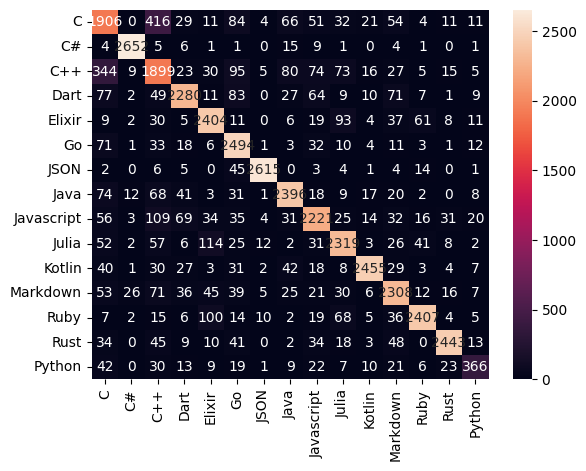

In [32]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', xticklabels=TARGET, yticklabels=TARGET)